# Setup

In [1]:
import os
os.chdir('..')
print(os.getcwd())

/Users/zekiyan/Library/CloudStorage/GoogleDrive-zettayan@gmail.com/My Drive/Entrepreneur/Sundai/Projects/satellite_image_recognition/Satellite_Image_Object_Recognition


# Packages & Utils

In [2]:
# import packages
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

from tensorflow.keras.models import load_model

In [3]:
# import utils
from utils.utils import get_label_mappings, conv_block, decoder_block, build_inception_resnetv2_unet, rgb_to_onehot, onehot_to_rgb, dice_coef, filter_mask_colors, convert_to_transparent_png, mask_images, display_image_with_mask

# Color Map

In [4]:
class_dict_df, code2id, id2code, name2id, id2name = get_label_mappings()

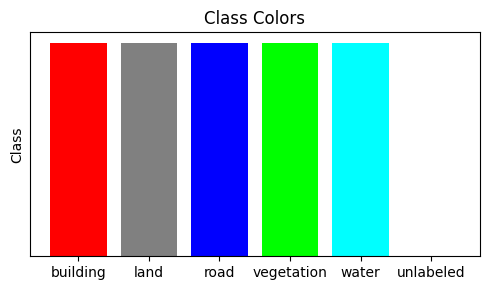

In [5]:
# Create a list of RGB tuples from the DataFrame
colors = [(r/255, g/255, b/255) for r, g, b in zip(class_dict_df['r'], class_dict_df['g'], class_dict_df['b'])]

# Plotting each class with its corresponding RGB color
fig, ax = plt.subplots(figsize=(5, 3))

# Plot each class as a separate bar with its RGB color
ax.bar(class_dict_df['name'], [1]*len(class_dict_df), color=colors)

# Adding labels and title
ax.set_ylabel('Class')
ax.set_title('Class Colors')
ax.set_yticks([])  # Remove y-axis ticks as they are not needed

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

# Modeling

In [6]:
K.clear_session()

In [7]:
model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 255, 255, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 255, 255, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 255, 255, 32)         0         ['batch_n

In [8]:
model.load_weights("model/InceptionResNetV2-UNet.h5")

1/1 [==============================] - 2s 2s/step


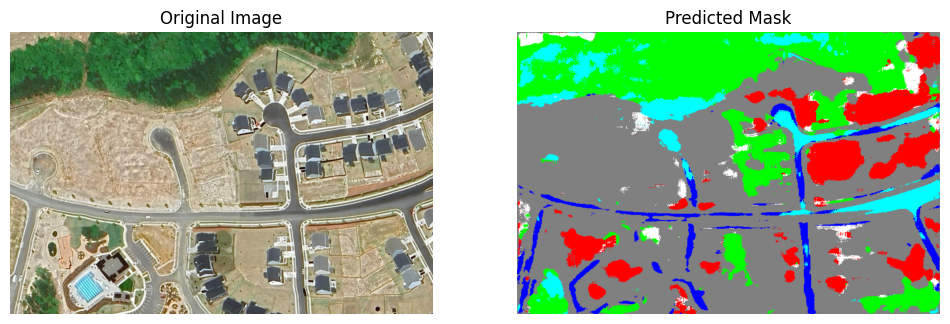

In [9]:
# Define the path to the image
image_path = "upload/SerenityCommunity1920By1280_v1_20241229.jpg"

# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (512, 512))  # Resize to match model input size
image_array = np.expand_dims(image_resized, axis=0) / 255.0  # Normalize and add batch dimension

# Make prediction
predicted_mask = model.predict(image_array)

# Convert the predicted mask to RGB
predicted_mask_rgb = onehot_to_rgb(predicted_mask[0], id2code)

# Resize the predicted mask back to the original image dimensions
original_height, original_width = image.shape[:2]
predicted_mask_resized = cv2.resize(predicted_mask_rgb, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask_resized)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

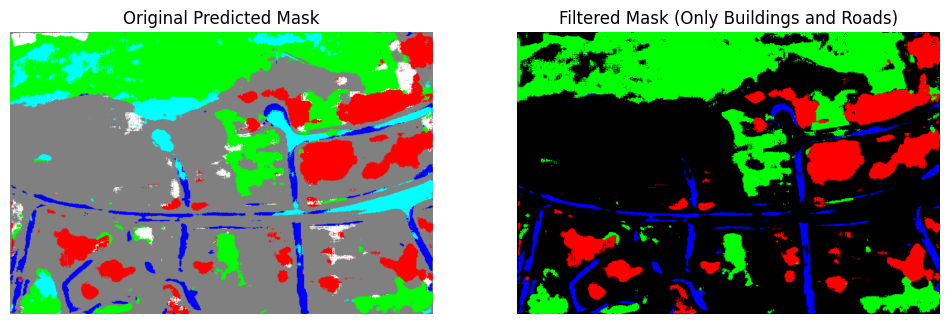

In [10]:
# Filter the mask to keep only red (buildings) and blue (roads)
colors_to_keep = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
filtered_mask = filter_mask_colors(predicted_mask_resized, colors_to_keep)

# Display the filtered mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predicted_mask_resized)
plt.title('Original Predicted Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_mask)
plt.title('Filtered Mask (Only Buildings and Roads)')
plt.axis('off')

plt.show()

In [11]:
# Save the filtered mask as transparent PNG
convert_to_transparent_png(filtered_mask, 'output/filtered_mask.png')

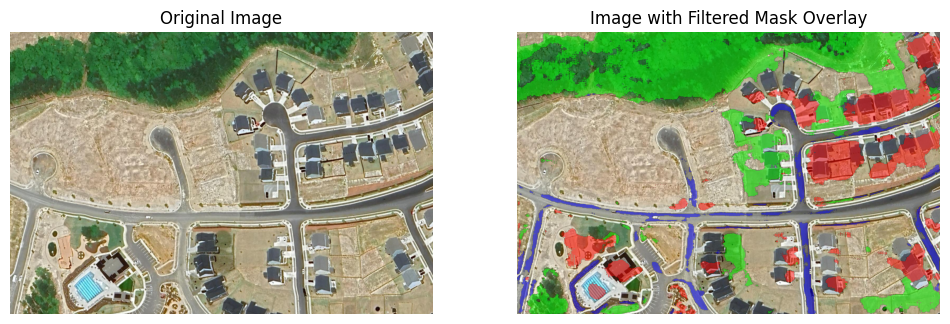

In [12]:
# Load and resize images
target_size = (1280, 1920)
original_image, filtered_mask = mask_images(
    'upload/SerenityCommunity1920By1280_v1_20241229.jpg',
    'output/filtered_mask.png',
    target_size
)

# Display results
display_image_with_mask(original_image, filtered_mask)

# Save the overlaid result
plt.figure(figsize=(12, 6))
plt.imshow(original_image)
plt.imshow(filtered_mask, alpha=0.5)
plt.axis('off')
plt.savefig('output/result_origin.jpg', bbox_inches='tight', pad_inches=0)
plt.close()

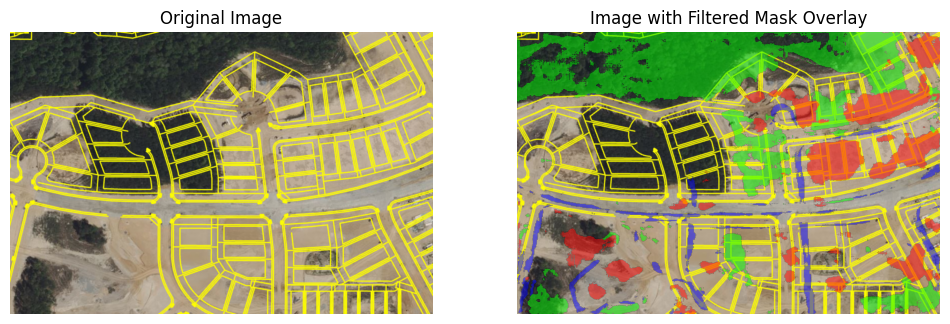

In [13]:
# Load and resize images
target_size = (1280, 1920)
original_image, filtered_mask = mask_images(
    'upload/SerenityCloseUp_v0_20241229.jpg',
    'output/filtered_mask.png',
    target_size
)

# Display results
display_image_with_mask(original_image, filtered_mask)

# Save the overlaid result
plt.figure(figsize=(12, 6))
plt.imshow(original_image)
plt.imshow(filtered_mask, alpha=0.5)
plt.axis('off')
plt.savefig('output/result_cad.jpg', bbox_inches='tight', pad_inches=0)
plt.close()